# Linguistic Analyses for Compositional Abstractions
## Notebook 2: Learning part concepts with program abstraction

This notebook was written by Will McCarthy.  
Original modeling by Haoliang Wang, Will McCarthy, Cameron Holdaway, Robert Hawkins, and Judy Fan.

*Note: this notebook serves as the instructor version and should be altered to the student version before being presented*

In the previous section, we saw that *Architects* used increasingly concise language to describe the scenes they were viewing. In particular, we saw that they started to use words that referred to increasingly complex entities, moving from instructions about individual blocks to entire towers.

Here we try to explain this trend through the lens of *abstraction*. We hypothesize that, as people are exposed to scenes that have elements in common, they acquire a vocabulary of part concepts that they can use represent and talk about each scene more concisely. To formalize this notion, we use *programmatic representations* of scenes, which support and amodal notion of abstraction, in the form of *program fragments*. In this notebook we explore a mechanism for learning program fragments as a model for the acquisition of part concepts.

This section is divided into three sections.  
**Section 1** explains the programmatic representations we will work with.  
**Section 2** covers the aquisition of part concepts over trials.  
**Section 3** covers the refactoring of scene programs into more concise programs involving these part concepts.

### Setup

In [3]:
import os
import sys
import urllib, io
os.getcwd()

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast
import pickle

import seaborn as sns

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [4]:
sys.path.append("../model/lib_learning/")

from program import *
import utilities
import render
from parse import *

from towerPrimitives import primitives
from makeTowerTasks import *
from grammar import *
from fragmentGrammar import *
from gen_seq import *
from enumeration import *
import importlib

## Part 1: Representing block towers as programs

In this project we want to explore how people build on top of existing knowledge over a short interaction. We therefore assume a basic level of understanding of block building concepts, encapsulated in a *domain specific language* (DSL).

Our *base DSL* (adapted from the [Dreamcoder building task](https://arxiv.org/abs/2006.08381)), contains the following primitives:
- **h**: horizontal domino
- **v**: vertical domino
- **l_x**: move left x places,  where x in {1,2,3,4,5,6,7,8,9,10,11,12}
- **r_x**: move right x places, where x in {1,2,3,4,5,6,7,8,9,10,11,12}

We manually define a unique program for each scene. For example, the scene with the C-tower on the left and L-tower on the right is represented as:  
    `h l_1 v v r_1 h r_12 h l_4 h l_1 v v`

In [5]:
manual_tower_programs = {"CL" :"h l_1 v v r_1 h r_12 h l_4 h l_1 v v",
                         "CPi": "h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h",
                         "PiC": "v r_6 v l_5 h r_4 h r_7 h l_1 v v r_1 h",
                         "LPi": "h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h",
                         "LC": "h l_4 h l_1 v v r_12 h l_1 v v r_1 h",
                         "PiL": "v r_6 v l_5 h r_4 h r_9 h l_4 h l_1 v v"}

### <span style="color: orange"> Possible exercise: follow through the program for a specific scene [include image] to make sure you know how the dsl is implemented </span>

## Part 2: Library learning

In this section we formalize abstraction learning as the discovery of *program fragments*. Fragments express part of a program with a single token. By augmenting the base DSL with these additional program fragments, we create a new DSL that can be used to express scenes more efficiently (i.e. with fewer tokens). This benefit comes at the cost of storing the new abstractions in memory.

This trade-off is captured by the abstraction learning algorithm, [Dreamcoder](https://arxiv.org/abs/2006.08381). Dreamcoder proposes program fragments more or less readily, depending on a weighting parameter, *w*. To keep things simple, here we consider a small range of *w*s that produce a reasonable range of learning rates.

This is important, as we use Dreamcoder to capture the *change in DSLs* across trials. As the model is exposed to more scenes (programs), program fragments are added to the DSL, and scenes are able to be expressed with shorter programs. This is meant to capture the ability of participants to reason about structures larger than individual blocks.

### Running dreamcoder

To save time, we have run the library learning phase of Dreamcoder for you on a range of weights. 

The output of Dreamcoder, for each participant, for each weight, is a series of DSLs-- one for each trial.

These DSLs are saved in `./data/model/dsls/`.

In [101]:
ws = [1.5, 3.3, 9.6] # values of w we are considering
w_index = {w: i for i, w in enumerate(ws)} # positional index of w
w_index = {1.5 : 0,
           3.3 : 2,
           9.6: 3}
trials = range(1,13)
ppts = range(1,50)

In [102]:
# Read in the DSLs learned by dreamcoder

data_path = '../data/model/dsls/'

dsls = {}
trial_seqs = {}

for ppt in range(1,50):
    
    dsls[ppt] = {}
    
    # read participants' trial sequence
    with open(data_path+f"{ppt}/configs.p", "rb") as config_file:
            trial_seqs[ppt] = pickle.load(config_file)
    
    # read inferred DSLs
    for trial in range(1, 13):
        with open(data_path+f"{ppt}/{trial}.p", "rb") as input_file:
            dsls[ppt][trial] = pickle.load(input_file)

def check_values(value, valid_values, parameter_type):
    if value not in valid_values:
        raise ValueError(f'{parameter_type} must be one of the following values: {valid_values}.')
            
def read_library(ppt, trial, w = 3.2, base_dsl_only=True):
    '''
    Returns dsl learned by dreamcoder
    '''
    check_values(ppt, range(1, 50), 'ppt')
    check_values(trial, range(1, 13), 'trial')
    check_values(w, ws, 'w')
    
    lib = [parse(str(fragment), base_dsl_only=base_dsl_only) for fragment in dsls[ppt][trial][w_index[w]]]
        
    
    return lib

In [103]:
## MASKED FROM STUDENT VERSION

In [105]:
read_library(ppt = 49, 
             trial = 3,
             w = 3.3,
             base_dsl_only=True
            )

['h l_1 v v']

In [106]:
# inspect libraries learned for a particular participant, trial, and w

read_library(ppt = 1, 
             trial = 12,
             w = 3.3,
             base_dsl_only=True)

['v r_6 v l_5 h r_4 h', 'h l_1 v v', 'h l_4 h l_1 v v', 'h l_1 v v r_1 h']

We're currently displaying each fragment as a program in the base DSL, but the whole point of learning fragments is that you can express them as a single token.

If we were fully automating this process, we might use an ID to label each learned fragment. In this example, only a handful of fragments are learned. This makes it possible to give each fragment a more helpful, human-readable name. If we change `base_dsl_only` to `False` then we can give these learned fragments helpful names.

In [112]:
read_library(ppt = 1, 
             trial = 12,
             w = 3.3,
             base_dsl_only=False)

['chunk_Pi', 'chunk_8', 'chunk_L', 'chunk_C']

We refer to all these learned abstractions as "chunks". 

- `chunk_8`, `chunk_8b`, `chunk_9` are subtower expressions (capturing several block placements)
- `chunk_Pi`, `chunk_C` and `chunk_L`, are distinct block towers. 
- `chunk_CPi` (and other chunks with two of C, L, and Pi) are single abstractions that capture the entire scene.

There are also a few unnamed chunks (mostly rarely occuring, small chunks consisting of e.g. a block and move). You might come across some of these as `chunk_un`

## <span style="color: orange"> Exercise: Explore libraries</span>

Now we'd like to know how libraries change across trials, as well as what this looks like for different values of w.

First try printing an entire sequence of libraries for one participant.  
Then, try to calculate some basic summary statistics across participants. One thing that might differ is the size of the library. 


In [109]:
# Find the series of libraries for a specific weight and participant

[read_library(ppt = 1, 
             trial = trial,
             w = 3.3,
             base_dsl_only=False) for trial in range(1,13)]

[[],
 [],
 ['chunk_8b'],
 ['chunk_8b', 'chunk_Pi'],
 ['chunk_8', 'chunk_Pi', 'chunk_L', 'chunk_C'],
 ['chunk_8', 'chunk_Pi', 'chunk_L', 'chunk_C'],
 ['chunk_8', 'chunk_Pi', 'chunk_L', 'chunk_C'],
 ['chunk_8', 'chunk_Pi', 'chunk_L', 'chunk_C'],
 ['chunk_Pi', 'chunk_8', 'chunk_L', 'chunk_C'],
 ['chunk_8', 'chunk_Pi', 'chunk_L', 'chunk_C'],
 ['chunk_Pi', 'chunk_8', 'chunk_L', 'chunk_C'],
 ['chunk_Pi', 'chunk_8', 'chunk_L', 'chunk_C']]

In [110]:
# Find the series of libraries for a specific weight and participant

libs = [[read_library(ppt = ppt, 
             trial = trial,
             w = 1.5,
             base_dsl_only=False) for trial in range(1,13)] for ppt in range(1,50)]

In [111]:
pd.Series([y for ys in [x for xs in libs for x in xs] for y in ys]).value_counts()

chunk_Pi     510
chunk_C      490
chunk_L      487
chunk_8      428
chunk_CPi    248
chunk_LPi    145
chunk_8b     105
chunk_PiC    105
chunk_un      41
chunk_PiL     20
chunk_CL      18
dtype: int64

1. Library size
2. Library content
3. 

## Part 3: Representing scenes more concisely with refactored programs

Now we have inferred the libraries of part concepts available to each participant in each trial. These part concepts, or program fragments, allow each scene program to be expressed more efficiently. In the next notebook, the model makes a decision about whether to use the most efficient program available to it, or play it safe and use lower-level language (about individual blocks). Before we get there, we first need to find these efficient programs.

How to search for programs given a DSL is an interesting research question in itself. Here, however, our focus is on how people choose between more or less efficient ways of expressing a concept, given uncertainty about what their partner will understand. For our purposes, we just need to select the single most efficient program that represents each scene. Fortunately for us, Dreamcoder libraries uniquely determine this most efficient programs. Programs involving larger abstractions can easily be found through enumeration. For less compressed programs, enumeration takes too long, however, we can simply swap in the learned abstractions from our DSLs through string-matching.

In [40]:
w = 3.3
w_position = w_index[w]

In [64]:
importlib.reload(refactorPrograms)
from refactorPrograms import * 

In [70]:
# refactor the programs
refactor_programs(dsls,
                  trial_seqs,
                  w_position = w_position)

Programs saved in ../data/model/your_programs/programs_ppt_[ppt].json


In [76]:
# inspect programs

ppt = 1

ppt_data = pd.read_json('../data/model/your_programs/programs_ppt_{}.json'.format(ppt))
ppt_data

,ppt,trial_num,towers,dsl_lambda,chunks,dsl,min_program,programs_with_length
0,1,1,LPi,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",[],"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,{'h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h': 14}
1,1,2,LC,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",[],"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",h l_4 h l_1 v v r_12 h l_1 v v r_1 h,{'h l_4 h l_1 v v r_12 h l_1 v v r_1 h': 13}
2,1,3,CPi,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",[],"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h,{'h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h': 14}
3,1,4,PiC,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",[chunk_8b],"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",v r_6 v l_5 h r_4 h r_7 chunk_8b r_1 h,"{'v r_6 v l_5 h r_4 h r_7 chunk_8b r_1 h': 11,..."
4,1,5,CL,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","[chunk_8b, chunk_Pi]","[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",chunk_8b r_1 h r_12 h l_4 chunk_8b,"{'chunk_8b r_1 h r_12 h l_4 chunk_8b': 7, 'h l..."
5,1,6,PiL,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","[chunk_8, chunk_Pi, chunk_L, chunk_C]","[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",chunk_Pi r_9 chunk_L,"{'chunk_Pi r_9 chunk_L': 3, 'v r_6 v l_5 h r_4..."
6,1,7,LC,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","[chunk_8, chunk_Pi, chunk_L, chunk_C]","[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",chunk_L r_12 chunk_C,"{'chunk_L r_12 chunk_C': 3, 'h l_4 h l_1 v v r..."
7,1,8,CPi,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","[chunk_8, chunk_Pi, chunk_L, chunk_C]","[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",chunk_C r_6 chunk_Pi,"{'chunk_C r_6 chunk_Pi': 3, 'chunk_C r_6 v r_6..."
8,1,9,LPi,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","[chunk_8, chunk_Pi, chunk_L, chunk_C]","[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",chunk_L r_9 chunk_Pi,"{'chunk_L r_9 chunk_Pi': 3, 'chunk_L r_9 v r_6..."
9,1,10,CL,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","[chunk_Pi, chunk_8, chunk_L, chunk_C]","[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",chunk_C r_12 chunk_L,"{'chunk_C r_12 chunk_L': 3, 'chunk_C r_12 h l_..."


## <span style="color: orange"> Exercise: Explore the programs</span>

We now have, for each participant, the most concise way of expressing each scene program (min_program). Take a look at these programs and try to make sense of them. Do they get longer or shorter over trials?

**Hint**: This exploration is analagous to the message length analysis in the previous notebook.

In [83]:
ppt = 1

all_program_data = pd.DataFrame()

for ppt in range(1,50):

    with open("../data/model/your_programs/programs_ppt_" + str(ppt) + ".json", "r") as read_file:
        trial_data = pd.read_json(read_file)
        all_program_data = pd.concat([all_program_data, trial_data], ignore_index=True)

<AxesSubplot:xlabel='trial_num', ylabel='min_prog_length'>

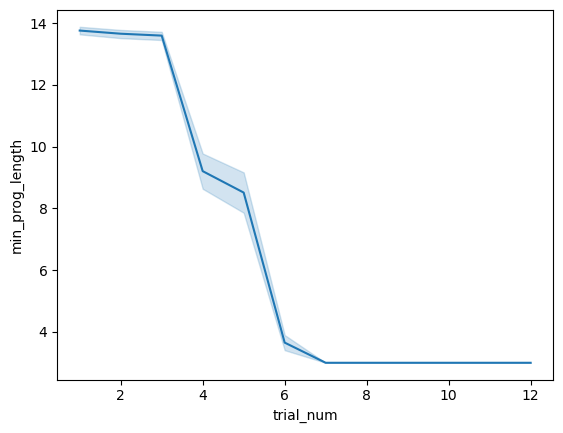

In [97]:
all_program_data['min_prog_length'] = all_program_data.min_program.apply(lambda x: len(x.split(' ')))

sns.lineplot(data = all_program_data,
         x = 'trial_num',
         y = 'min_prog_length')

<AxesSubplot:xlabel='rep', ylabel='min_prog_length'>

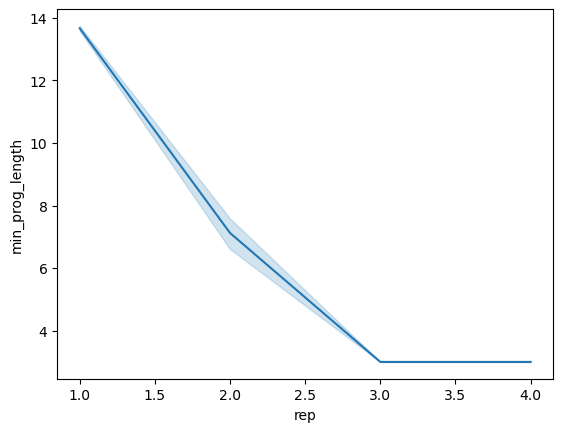

In [98]:
all_program_data['rep'] = all_program_data.trial_num.apply(lambda n: np.ceil(n/3))


sns.lineplot(data = all_program_data,
         x = 'rep',
         y = 'min_prog_length')

### Summary

We've seen how we can model the learning of part concepts as adding program fragments to a library. We've seen that doing so allows us to express a scene program more concisely, and generated programs using more or less of these fragments to create a range of programs with varying concision.

In the [final notebook](/notebooks/conventions.ipynb), we explore how people might weigh this concision against another factor-- informativity.

Woohoo! Notebook 2 complete! Have a stretch, go for a walk, drink some water.



In [114]:
df_ref_exps = pd.read_csv('../data/df_ref_exps.csv')

In [122]:
rater_num = {name: i for i, name in enumerate(df_ref_exps.workerID.unique())}

In [125]:
df_ref_exps.workerID = df_ref_exps.workerID.apply(lambda a: rater_num[a])

In [126]:
df_ref_exps.

,Unnamed: 0,dyad_gameid,trial_num,turn_num,message_id,workerID,block,phrases,scene,tower,message_num,message,content,refExps,leftTarget,rightTarget,tower_pair,rep
0,0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,0,2,two blue,0.0,0,0,two blue blocks on left and right side of left...,two blue,NaN,L,Pi,L_Pi,1
1,1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,1,2,two blue blocks,0.0,0,0,two blue blocks on left and right side of left...,two blue blocks,NaN,L,Pi,L_Pi,1
2,2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,0,2,two red,0.0,0,1,two red block on top of left blue block just p...,two red,NaN,L,Pi,L_Pi,1
3,3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,1,2,two red block,0.0,0,1,two red block on top of left blue block just p...,two red block,NaN,L,Pi,L_Pi,1
4,4,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,4,d39dd7ca-1fde-56c1-9d41-a10b16b3d17d,0,2,two red,0.0,0,2,two red block one space apart on right line,two red,NaN,L,Pi,L_Pi,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8567,8567,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,11.0,2,ae9e8d03-8498-3111-371a-239070c742d0,3,1,NaN,NaN,0,1,same on the opposite side,same,"same,",Pi,L,Pi_L,4
8568,8568,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,11.0,4,24b27e83-01cb-d9c2-d35f-581e3648431f,3,2,NaN,NaN,0,2,close it up with two blues,two blues,"two blues,",Pi,L,Pi_L,4
8569,8569,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,11.0,6,17668e8a-78ca-810e-7428-63563c91e458,3,1,NaN,NaN,0,3,take a blue and place it to the right of right...,blue,"blue,",Pi,L,Pi_L,4
8570,8570,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,11.0,8,a622053d-d5ff-7894-46ac-32019ab1874e,3,1,NaN,NaN,0,4,another blue placed next to it on the left side,blue,"blue,",Pi,L,Pi_L,4
